In [8]:
!pip install tensorflow pillow matplotlib scipy

  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   -

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.33.1 which is incompatible.


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ==========================================
# 1. SETUP PATHS
# ==========================================
# Main folder
base_dir = r"C:\Users\rpraj\Music\DS-PROJ-5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data"

# Point specifically to the 'train' and 'val' folders we found
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

print(f"Checking Training Folder: {train_dir}")
if os.path.exists(train_dir):
    print(f" Training data found! Classes inside: {len(os.listdir(train_dir))}")
else:
    print(" Error: Could not find training folder.")

# ==========================================
# 2. LOAD DATA (No split needed now)
# ==========================================
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# We removed 'validation_split=0.2' because folders are already split
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

print("\n--- 1. Loading Training Data ---")
train_generator = datagen.flow_from_directory(
    train_dir,              # Pointing to 'train' folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\n--- 2. Loading Validation Data ---")
val_generator = datagen.flow_from_directory(
    val_dir,                # Pointing to 'val' folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Print the fish names
print(f"\n Fish Types Found: {list(train_generator.class_indices.keys())}")

Checking Training Folder: C:\Users\rpraj\Music\DS-PROJ-5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train
 Training data found! Classes inside: 11

--- 1. Loading Training Data ---
Found 6225 images belonging to 11 classes.

--- 2. Loading Validation Data ---
Found 1092 images belonging to 11 classes.

 Fish Types Found: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG16, InceptionV3, ResNet50, EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# 1. Get the number of fish types (Should be 11)
num_classes = len(train_generator.class_indices)
print(f" Preparing to train on {num_classes} types of fish.")

 Preparing to train on 11 types of fish.


In [4]:
# 2. Define the Custom CNN 
def build_custom_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [5]:
# 3. Define the Transfer Learning Helper (For VGG16, MobileNet, etc.)
def build_transfer_model(base_model_class):
    # Download the pre-trained brain
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze it so we don't break what it already knows
    
    # Add our fish-specific layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=predictions)

In [6]:
# 4. Define the Training Function
def train_specific_model(model, filename, model_name):
    print(f"\n STARTING TRAINING: {model_name}")
    print(f"   Saving to: {filename}")
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Save the best version automatically
    checkpoint = ModelCheckpoint(filename, monitor='val_accuracy', save_best_only=True, verbose=1)
    
    # Stop early if it stops learning (saves time)
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # TRAIN!
    model.fit(train_generator, 
              epochs=10,  # Change to 3 or 5 if you want it faster
              validation_data=val_generator, 
              callbacks=[checkpoint, early_stop])
    
    print(f" FINISHED: {model_name} saved successfully.\n")

In [10]:
model = build_transfer_model(MobileNet)
train_specific_model(model, "mobilenet_fish_model.h5", "MobileNet")


 STARTING TRAINING: MobileNet
   Saving to: mobilenet_fish_model.h5
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3832 - loss: 1.8990
Epoch 1: val_accuracy improved from None to 0.91758, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.5656 - loss: 1.3436 - val_accuracy: 0.9176 - val_loss: 0.5514
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8340 - loss: 0.5760
Epoch 2: val_accuracy improved from 0.91758 to 0.95696, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8585 - loss: 0.5027 - val_accuracy: 0.9570 - val_loss: 0.2600
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9175 - loss: 0.3108
Epoch 3: val_accuracy improved from 0.95696 to 0.97070, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9259 - loss: 0.2862 - val_accuracy: 0.9707 - val_loss: 0.1515
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.9510 - loss: 0.2061 
Epoch 4: val_accuracy improved from 0.97070 to 0.98901, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.9533 - loss: 0.1930 - val_accuracy: 0.9890 - val_loss: 0.1017
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9667 - loss: 0.1514
Epoch 5: val_accuracy did not improve from 0.98901
195/195 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9672 - loss: 0.1409 - val_accuracy: 0.9844 - val_loss: 0.0841
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.9739 - loss: 0.1157
Epoch 6: val_accuracy did not improve from 0.98901
195/195 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9730 - loss: 0.1123 - val_accuracy: 0.9872 - val_loss: 0.0666
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.9798 - loss: 0.0907
Epoch 7: val_accuracy improved from 0.98901 to 0.99084, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9780 - loss: 0.0900 - val_accuracy: 0.9908 - val_loss: 0.0634
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9832 - loss: 0.0791
Epoch 8: val_accuracy did not improve from 0.99084
195/195 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.9827 - loss: 0.0767 - val_accuracy: 0.9899 - val_loss: 0.0484
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.9854 - loss: 0.0686
Epoch 9: val_accuracy improved from 0.99084 to 0.99176, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9849 - loss: 0.0682 - val_accuracy: 0.9918 - val_loss: 0.0406
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.9862 - loss: 0.0627
Epoch 10: val_accuracy improved from 0.99176 to 0.99359, saving model to mobilenet_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.9862 - loss: 0.0603 - val_accuracy: 0.9936 - val_loss: 0.0409
 FINISHED: MobileNet saved successfully.



In [14]:
model = build_transfer_model(InceptionV3)
train_specific_model(model, "inceptionv3_fish_model.h5", "InceptionV3")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 109s 1us/step

 STARTING TRAINING: InceptionV3
   Saving to: inceptionv3_fish_model.h5
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4856 - loss: 1.6036
Epoch 1: val_accuracy improved from None to 0.88645, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6631 - loss: 1.0657 - val_accuracy: 0.8864 - val_loss: 0.4626
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8678 - loss: 0.4641
Epoch 2: val_accuracy improved from 0.88645 to 0.93498, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.8786 - loss: 0.4159 - val_accuracy: 0.9350 - val_loss: 0.2853
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9063 - loss: 0.3245
Epoch 3: val_accuracy improved from 0.93498 to 0.94872, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9120 - loss: 0.3056 - val_accuracy: 0.9487 - val_loss: 0.2155
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9270 - loss: 0.2453
Epoch 4: val_accuracy did not improve from 0.94872
195/195 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - accuracy: 0.9306 - loss: 0.2323 - val_accuracy: 0.9441 - val_loss: 0.1873
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9348 - loss: 0.2093
Epoch 5: val_accuracy improved from 0.94872 to 0.95238, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9422 - loss: 0.1900 - val_accuracy: 0.9524 - val_loss: 0.1563
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9505 - loss: 0.1641
Epoch 6: val_accuracy improved from 0.95238 to 0.96337, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9512 - loss: 0.1626 - val_accuracy: 0.9634 - val_loss: 0.1266
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9464 - loss: 0.1664
Epoch 7: val_accuracy improved from 0.96337 to 0.96978, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9526 - loss: 0.1534 - val_accuracy: 0.9698 - val_loss: 0.1086
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9599 - loss: 0.1287
Epoch 8: val_accuracy did not improve from 0.96978
195/195 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9619 - loss: 0.1279 - val_accuracy: 0.9606 - val_loss: 0.1229
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9594 - loss: 0.1241
Epoch 9: val_accuracy improved from 0.96978 to 0.97253, saving model to inceptionv3_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9619 - loss: 0.1162 - val_accuracy: 0.9725 - val_loss: 0.0946
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9675 - loss: 0.1166
Epoch 10: val_accuracy did not improve from 0.97253
195/195 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9701 - loss: 0.1039 - val_accuracy: 0.9716 - val_loss: 0.0910
 FINISHED: InceptionV3 saved successfully.



In [12]:
model = build_custom_cnn()
train_specific_model(model, "custom_cnn_model.h5", "Custom CNN")

c:\Users\rpraj\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 STARTING TRAINING: Custom CNN
   Saving to: custom_cnn_model.h5
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2848 - loss: 2.0354
Epoch 1: val_accuracy improved from None to 0.60073, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.3896 - loss: 1.7671 - val_accuracy: 0.6007 - val_loss: 1.2562
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5483 - loss: 1.3560
Epoch 2: val_accuracy improved from 0.60073 to 0.71978, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.5671 - loss: 1.2933 - val_accuracy: 0.7198 - val_loss: 0.9628
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6121 - loss: 1.1289
Epoch 3: val_accuracy improved from 0.71978 to 0.76740, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6366 - loss: 1.0762 - val_accuracy: 0.7674 - val_loss: 0.7766
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.6726 - loss: 0.9548
Epoch 4: val_accuracy improved from 0.76740 to 0.83425, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6898 - loss: 0.9188 - val_accuracy: 0.8342 - val_loss: 0.6325
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7286 - loss: 0.8346
Epoch 5: val_accuracy improved from 0.83425 to 0.85073, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.7489 - loss: 0.7829 - val_accuracy: 0.8507 - val_loss: 0.5206
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7856 - loss: 0.6635
Epoch 6: val_accuracy improved from 0.85073 to 0.90385, saving model to custom_cnn_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.7822 - loss: 0.6731 - val_accuracy: 0.9038 - val_loss: 0.4296
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7969 - loss: 0.6182
Epoch 7: val_accuracy did not improve from 0.90385
195/195 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8027 - loss: 0.6004 - val_accuracy: 0.8956 - val_loss: 0.3736
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8152 - loss: 0.5638
Epoch 8: val_accuracy did not improve from 0.90385
195/195 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.8127 - loss: 0.5617 - val_accuracy: 0.8938 - val_loss: 0.3579
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8308 - loss: 0.5218
Epoch 9: val_accuracy did not improve from 0.90385
195/195 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8357 - loss: 0.5055 - val_accuracy: 0.9038 - val_loss: 0.3499
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8505 - loss: 0.4509
Epoch 10: val_accuracy improved fr

195/195 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.8471 - loss: 0.4529 - val_accuracy: 0.9423 - val_loss: 0.2514
 FINISHED: Custom CNN saved successfully.



In [7]:
model = build_transfer_model(VGG16)
train_specific_model(model, "vgg_fish_model.h5", "VGG16")


 STARTING TRAINING: VGG16
   Saving to: vgg_fish_model.h5
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1845 - loss: 2.2975
Epoch 1: val_accuracy improved from None to 0.42216, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1601s 8s/step - accuracy: 0.2315 - loss: 2.1881 - val_accuracy: 0.4222 - val_loss: 1.9730
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3528 - loss: 1.9300
Epoch 2: val_accuracy improved from 0.42216 to 0.56502, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1527s 8s/step - accuracy: 0.3880 - loss: 1.8605 - val_accuracy: 0.5650 - val_loss: 1.7327
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4929 - loss: 1.6869
Epoch 3: val_accuracy improved from 0.56502 to 0.65934, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1546s 8s/step - accuracy: 0.5194 - loss: 1.6387 - val_accuracy: 0.6593 - val_loss: 1.5466
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5608 - loss: 1.5253
Epoch 4: val_accuracy improved from 0.65934 to 0.69780, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1550s 8s/step - accuracy: 0.5836 - loss: 1.4762 - val_accuracy: 0.6978 - val_loss: 1.3856
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6408 - loss: 1.3552
Epoch 5: val_accuracy improved from 0.69780 to 0.73535, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1623s 8s/step - accuracy: 0.6408 - loss: 1.3345 - val_accuracy: 0.7353 - val_loss: 1.2584
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6775 - loss: 1.2377
Epoch 6: val_accuracy improved from 0.73535 to 0.74084, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1628s 8s/step - accuracy: 0.6839 - loss: 1.2110 - val_accuracy: 0.7408 - val_loss: 1.1490
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7081 - loss: 1.1464
Epoch 7: val_accuracy improved from 0.74084 to 0.79121, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1670s 9s/step - accuracy: 0.7133 - loss: 1.1103 - val_accuracy: 0.7912 - val_loss: 1.0414
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7244 - loss: 1.0383
Epoch 8: val_accuracy improved from 0.79121 to 0.80952, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 3303s 17s/step - accuracy: 0.7324 - loss: 1.0231 - val_accuracy: 0.8095 - val_loss: 0.9680
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7495 - loss: 0.9689
Epoch 9: val_accuracy improved from 0.80952 to 0.82234, saving model to vgg_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 1496s 8s/step - accuracy: 0.7491 - loss: 0.9554 - val_accuracy: 0.8223 - val_loss: 0.8923
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7728 - loss: 0.9009
Epoch 10: val_accuracy did not improve from 0.82234
195/195 ━━━━━━━━━━━━━━━━━━━━ 1787s 9s/step - accuracy: 0.7706 - loss: 0.8903 - val_accuracy: 0.8086 - val_loss: 0.8388
 FINISHED: VGG16 saved successfully.



In [7]:
model = build_transfer_model(EfficientNetV2B0)
train_specific_model(model, "effv2_fish_model.h5", "EfficientNetV2B0")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step

 STARTING TRAINING: EfficientNetV2B0
   Saving to: effv2_fish_model.h5
Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1631 - loss: 2.3258
Epoch 1: val_accuracy improved from None to 0.17125, saving model to effv2_fish_model.h5


195/195 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.1655 - loss: 2.3225 - val_accuracy: 0.1712 - val_loss: 2.3147
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1700 - loss: 2.3090
Epoch 2: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.1733 - loss: 2.3137 - val_accuracy: 0.1712 - val_loss: 2.3116
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1663 - loss: 2.3193
Epoch 3: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.1735 - loss: 2.3129 - val_accuracy: 0.1712 - val_loss: 2.3100
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1727 - loss: 2.3098
Epoch 4: val_accuracy did not improve from 0.17125
195/195 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.1737 - loss: 2.3085 - val_accuracy: 0.1712 - val_loss: 2.3068
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1710 - loss: 2.3101
Epoch 5: val_accuracy did not impro

 Found Validation Data at: C:\Users\rpraj\Music\DS-PROJ-5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val
Found 1092 images belonging to 11 classes.

 STARTING EVALUATION (This takes a moment)...

Testing: custom_cnn_model.h5...


    Accuracy: 93.41%

Testing: mobilenet_fish_model.h5...


    Accuracy: 99.27%

Testing: vgg_fish_model.h5...


    Accuracy: 81.41%

Testing: inceptionv3_fish_model.h5...


    Accuracy: 97.34%
    Skipping resnet50_fish_model.h5 (File not found)

Testing: effv2_fish_model.h5...


    Accuracy: 17.12%

 WINNER: mobilenet_fish_model.h5
 ACCURACY: 99.27%


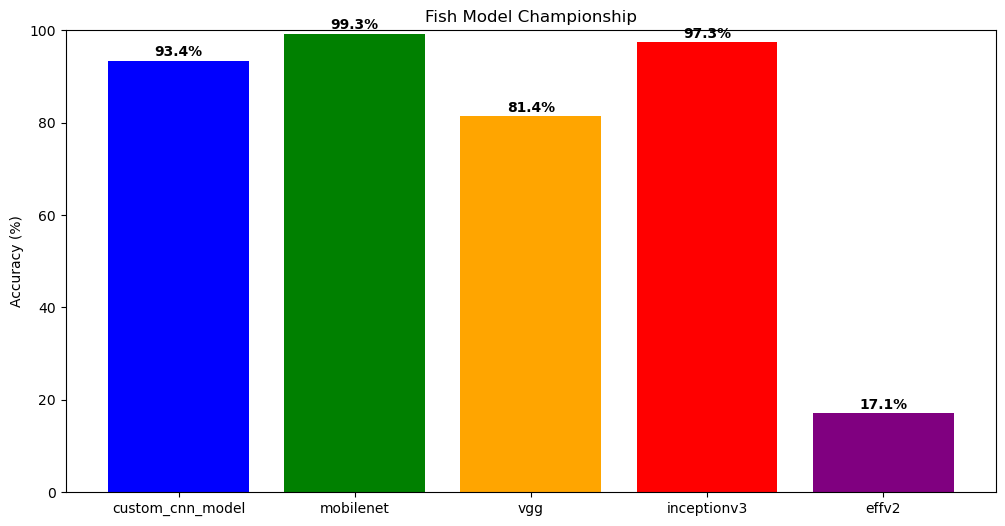

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. SETUP PATHS
# ==========================================
# PASTE YOUR CORRECT PATH HERE (The one ending in \data)
base_dir = r"C:\Users\rpraj\Music\DS-PROJ-5\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data"
val_dir = os.path.join(base_dir, 'val')

if not os.path.exists(val_dir):
    print(f" Error: Could not find {val_dir}")
else:
    print(f" Found Validation Data at: {val_dir}")

# ==========================================
# 2. PREPARE TEST DATA
# ==========================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(rescale=1./255)

# We use the validation folder to 'Quiz' the models
test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # IMPORTANT: Must be False for evaluation
)

# ==========================================
# 3. LIST OF MODELS TO CHECK
# ==========================================
# These match the filenames you just created
model_files = [
    "custom_cnn_model.h5",
    "mobilenet_fish_model.h5",
    "vgg_fish_model.h5",
    "inceptionv3_fish_model.h5",
    "resnet50_fish_model.h5",
    "effv2_fish_model.h5"
]

results = {}

print("\n STARTING EVALUATION (This takes a moment)...")

for filename in model_files:
    if os.path.exists(filename):
        print(f"\nTesting: {filename}...")
        try:
            # Load the model
            model = load_model(filename)
            
            # Run the test
            loss, acc = model.evaluate(test_generator, verbose=0)
            results[filename] = acc
            print(f"    Accuracy: {acc*100:.2f}%")
            
        except Exception as e:
            print(f"    Error loading {filename}: {e}")
    else:
        print(f"    Skipping {filename} (File not found)")

# ==========================================
# 4. SHOW THE WINNER
# ==========================================
if len(results) > 0:
    # Find best model
    best_model_name = max(results, key=results.get)
    best_acc = results[best_model_name]

    print("\n" + "="*40)
    print(f" WINNER: {best_model_name}")
    print(f" ACCURACY: {best_acc*100:.2f}%")
    print("="*40)

    # Plot Chart
    plt.figure(figsize=(12, 6))
    names = [n.replace('_fish_model.h5', '').replace('.h5', '') for n in results.keys()]
    values = [v * 100 for v in results.values()]
    
    plt.bar(names, values, color=['blue', 'green', 'orange', 'red', 'purple', 'cyan'])
    plt.ylabel('Accuracy (%)')
    plt.title('Fish Model Championship')
    plt.ylim(0, 100)
    
    for i, v in enumerate(values):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
        
    plt.show()
else:
    print("\n No models were found to evaluate!")